## About

Sample notebook to fecth ECG, calculate HR abd HRV values

In [2]:
root_folder = "./../"
sys.path.insert(1, root_folder)
sys.path.insert(1, os.path.join(root_folder, 'tools/'))

#%%
import sys
import getopt

#Imports
import numpy as np
import multiprocessing # todo
from os.path import join as ospj
import sys
import pandas as pd
import seaborn as sns
from ieeg.auth import Session
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
from tools import get_iEEG_data
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import iirnotch, filtfilt, butter, lfilter, medfilt

import warnings
warnings.filterwarnings("ignore")

import biosppy
from biosppy.signals import ecg
import pyhrv
import pyhrv.tools as tools
from pyhrv.hrv import hrv
import neurokit2 as nk
import heartpy as hp
import pyhrv.time_domain as td 
import pyhrv.frequency_domain as fd

from datetime import datetime, date, timedelta
import importlib

from scipy import signal
from scipy.signal import butter, lfilter, freqz, filtfilt, find_peaks, medfilt, ellip
from scipy.signal import savgol_filter, hilbert
import sys
import os
import json



from helpers import *


    

In [4]:
def remove_std(signal, std_mul=1.5):
    std_rem = signal.copy()
    mean = np.mean(std_rem)
    std = np.std(std_rem)
    std_rem[(std_rem<(mean+std_mul*std)) & (std_rem>(mean-std_mul*std))]=mean
    return std_rem

In [5]:
username = 'jalpanchal'
pwd_bin_path = "/users/jalp/tools/jal_ieeglogin.bin"
with open(pwd_bin_path, "r") as f:
    s = Session(username, f.read())   
    
#import login credentials
from cryptography.fernet import Fernet
import os
 
cred_filename = '/users/jalp/ieeg_credentials/CredFile.ini'
key_file = '/users/jalp/ieeg_credentials/key.key'
 
key = ''
 
with open(key_file,'r') as key_in:
    key = key_in.read().encode()
  
f = Fernet(key)
with open(cred_filename,'r') as cred_in:
    lines = cred_in.readlines()
    config = {}
    for line in lines:
        tuples = line.rstrip('\n').split('=',1)
        if tuples[0] in ('Username','Password'):
            config[tuples[0]] = tuples[1]
 
    password = f.decrypt(config['Password'].encode()).decode()
    user = config['Username']

### Load subject data and seizure timestamps

In [6]:
subject_data = pd.read_csv("./../../data/subject_data.csv")
print(subject_data)

  subject       portal_ID ecg_channel  ecg_multiplier
0  HUP173  HUP173_phaseII        EKG1              -1


In [7]:
clipdata = pd.read_excel("/users/pattnaik/ecg-ieeg/data/sub-RID0031/all_clip_times.xlsx")
clipdata

,Unnamed: 0,Start (sec),End (sec),Name
0,0,7999.895087,8299.895087,interictal_0
1,1,15954.057582,16254.057582,interictal_1
2,2,42718.602426,43018.602426,interictal_2
3,3,82432.561049,82732.561049,interictal_3
4,4,96922.219755,97222.219755,interictal_4
5,5,250033.301288,250333.301288,interictal_5
6,6,255312.541146,255612.541146,interictal_6
7,7,278975.390000,279275.390000,preictal_0_4hr
8,8,286175.390000,286475.390000,preictal_0_2hr
9,9,289775.390000,290075.390000,preictal_0_1hr


### Calculte data segments
1 min segments, can change to 5 mins
- Segments used from
/users/pattnaik/ecg-ieeg/data/sub-RID0031/all_clip_times.xlsx for each subject has the start and end timiing of each segment\

In [8]:
def calc_hrv_param(data, win_s, overlap_s):
    df = data.copy()

    start =df.index[0]
    stop = df.index[-1]

    hrv_windows = calc_windows(start, stop, win_s, overlap_s)

    hrv_df = pd.DataFrame()
    for i in tqdm(range(len(hrv_windows))):
        data = df[(df.index >=hrv_windows[i][0]) & (df.index <hrv_windows[i][1])]['heartRate']
        
        if len(data.dropna())>=2:

            nni_ms = 60000/data.values

            #dropping large nni values > 3000 ms
            nni_ms = nni_ms[nni_ms < 3000]



            # print(len(nni_ms))
            # td_results = td.time_domain(nni=nni_ms, rpeaks =rpeaks_ms, sampling_rate=fs,plot=False)
            parameters = ['rmssd', 'hf']

            # hrv_params = np.ones([len(data), len(parameters)])*np.nan
            # hrv_params[-1,0] =  int(td.rmssd(nni=nni_ms)[0])
            rmssd = int(td.rmssd(nni=nni_ms)[0])
            
            #frequency based parameter 
            # try:
            #     freq = fd.welch_psd(nni=nni_ms, show=False, mode='dev')[0]['fft_abs']
            #     hrv_params[-1,1] =  int(freq[2])
            # except : 
            #     hrv_params[-1,1] =  0
            
            hrv_df = hrv_df.append(pd.DataFrame(data={'rmssd' : rmssd, 'hrMean' : round(np.mean(data.values),1) }, index=[data.index[-1]]))

        else:
            continue
    return hrv_df    

def get_hr_hrv(subject_name, start_flag=0, end_flag=0 ):

    sub_data = subject_data[subject_data['subject']==subject_name]

    portal_name = sub_data['portal_ID'][0]
    # print("portal_name", portal_name)
    ecg_channels = [sub_data['ecg_channel'][0]]
    ecg_multiplier = sub_data['ecg_multiplier'][0]


    #Configuring getting  ieeg data
    # print("Getting data for %s" %(subject_name))
    # print("Getting data for %s from IEEG" %(portal_name))

    with open(pwd_bin_path, "r") as f:
        s = Session(username, f.read())
    ds = s.open_dataset(portal_name)

    if start_flag!=0:
        start_time_sec = int(start_flag)
    else:
        start_time_sec = 0

    if end_flag!=0:
        end_time_sec = int(end_flag)
    else:
        end_time_sec = (ds.end_time-ds.start_time)/1e6
    

    # print("time stamps retrived from IEEG")
    print("Getting data for %d to %d" %(start_time_sec, end_time_sec))

    data_pull_min=5

    clip_duration_sec =  end_time_sec - start_time_sec
    clip_duration_min = clip_duration_sec / 60

    # how many data_pull_min minute data pulls are there?
    n_iter = int(np.ceil(clip_duration_min / data_pull_min))


# %%
    
    hr_win = pd.DataFrame()
    for i in tqdm(range(n_iter)):

        start_usec = start_time_sec * 1e6 + i * (5 * 60 * 1e6)
        if i == n_iter - 1:
            end_usec = end_time_sec * 1e6
        else:
            end_usec = start_usec + (5 * 60 * 1e6)

        data, fs = get_iEEG_data(username, pwd_bin_path,portal_name , start_usec, end_usec, select_electrodes=ecg_channels)

        time = np.linspace(start_usec, end_usec, len(data), endpoint=False)
        data.index = pd.to_datetime(time, unit='us')


        # format resulting data into pandas DataFrame
        signal_filt = pd.DataFrame(columns=ecg_channels, index=data.index)


        hr_df = pd.DataFrame()
        for n,c in enumerate(ecg_channels):
            #remove baseline wander
            temp_ = hp.remove_baseline_wander(data.iloc[:,n]*ecg_multiplier, fs)


            #bandpas filter
            order = int(0.3 * fs)
            signal_filt[c], _, _ = biosppy.tools.filter_signal(signal=temp_,ftype='FIR',band='bandpass',order=order,frequency=[3,25],sampling_rate=fs)


            # work on 5s samples
            temp_std= pd.DataFrame()
            for i in range(int(len(signal_filt)/int(5*fs))):

                win_data = signal_filt[i*5*int(fs):(i+1)*5*int(fs)][c]

                #remove noise data < 1.5 std

                std_rem = remove_std(win_data, 1.5)
                temp_std = temp_std.append(pd.DataFrame(std_rem))

            try :
            
                out = ecg.ecg(signal=temp_std[c], sampling_rate=fs, show=False)
                # ecg_filtered = out[1]
                # rpeaks = out[2]
                heart_rate_ts = out[-2]
                heart_rate = out[-1]
                idx = (heart_rate_ts*fs).astype(int)

                temp_ = pd.DataFrame(data={c : heart_rate}, index=temp_std.index[idx])
                hr_df = hr_df.append(temp_)

                                
                #shift time to real time
                # hr_df.index = pd.to_datetime(hr_df.index).tz_localize(tz=tz)+ delta

                # resample to 1Hz
                hr_rs = hr_df.resample("1s").mean()   

                #take the min in each 1s window
                hr_min = hr_rs.min(axis=1)

                hr_win = hr_win.append(pd.DataFrame(hr_min.dropna()))
            except:
                    continue  

    # %%
    #smoothen
    hr_sm = pd.DataFrame({'heartRate' : savgol_filter(hr_win[0], 11,3)}, index=hr_win.index)
    hr_sm['heartRate'] = hr_sm['heartRate'].apply(lambda x : round(x,1))



    # %%
    #calc hrv parameters

    hrv_df = calc_hrv_param(hr_sm, 60,50) #60s window 50s overlap

    #combine df and add timestamp column
    combine_df = hr_sm.join(hrv_df)
    combine_df['timestamp'] = (combine_df.index.astype(int)/10e8).astype(int)
    combine_df = combine_df[['timestamp', 'heartRate', 'rmssd', 'hrMean']]

    return combine_df



### Running for each segment

In [15]:
for clip in clipdata.iterrows():
    start_time = clip[1]['Start (sec)']
    end_time = clip[1]['End (sec)']
    clip_name = clip[1]['Name']
    file_name = "./../../data/HUP173/HUP173_ecg_hr_hrv_"+clip_name

    hrv = get_hr_hrv('HUP173', start_flag=start_time, end_flag=end_time )
    hrv_np = hrv.to_numpy()
    np.save(file_name, hrv_np)

  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

### running HR-HRv for whole dataset

In [11]:
file_name = "./../../data/HUP173/HUP173_ecg_hr_hrv_test"
hrv = get_hr_hrv('HUP173', 0, 100000)
hrv_np = hrv.to_numpy()
np.save(file_name, hrv_np)

  0%|          | 0/334 [00:00<?, ?it/s]

Getting data for 0 to 100000


  2%|▏         | 6/334 [00:18<16:53,  3.09s/it]


KeyboardInterrupt: 

## Load smaple data

In [12]:
file_name = "HUP173_ecg_hr_hrv_alldata.npy"
file_path = "/mnt/leif/littlab/users/jalp/git/ecg-ieeg/data/HUP173/"+file_name
test_df = pd.DataFrame(np.load(file_path))
test_df.columns = ['timestamp', 'heartRate', 'rmssd', 'hrMean']

### Sample Plot

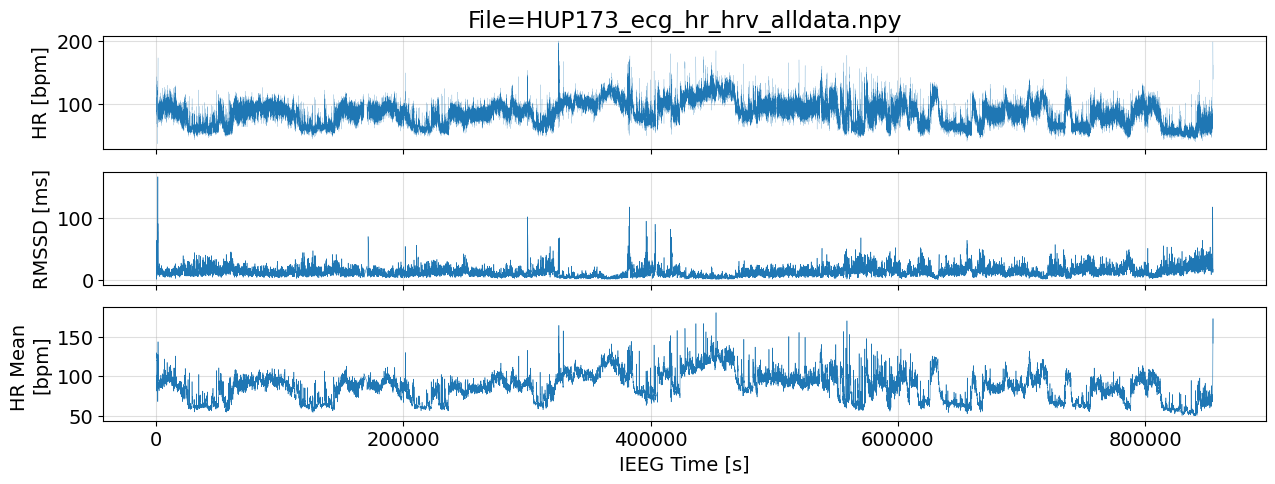

In [38]:
plt.rcParams["font.size"]=14
fig, ax = plt.subplots(3,1, figsize=(15,5), sharex=True)
user_data = test_df.copy()
axi = ax[0]
axi.plot(user_data['timestamp'],user_data['heartRate'], '-', lw=0.1)
axi.set_ylabel("HR [bpm]")
axi.set_title("File=%s"%(file_name))

data_copy = user_data.copy()
data_copy = data_copy.dropna()

axi = ax[1]
axi.plot(data_copy['timestamp'],data_copy['rmssd'], '-', lw=0.4)
axi.set_ylabel("RMSSD [ms]")
# axi.set_xlabel("IEEG Time [s]")

axi = ax[2]
axi.plot(data_copy['timestamp'],data_copy['hrMean'], '-', lw=0.4)
axi.set_ylabel("HR Mean \n[bpm]")
axi.set_xlabel("IEEG Time [s]")

for axp in ax.flatten():
    axp.grid(alpha=0.4)

plt.show()

In [16]:
dummy = user_data['rmssd']

len(user_data['heartRate'])

826296

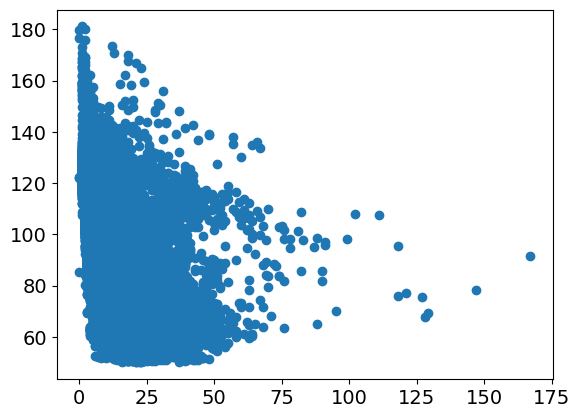

In [24]:
plt.plot(user_data['rmssd'], user_data['hrMean'], 'o')
plt.show()

In [20]:
826296*0.1

82629.6